<a href="https://colab.research.google.com/github/solobala/TSML13/blob/main/TSML13_DZ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание
 - Выберите ряд из первого задания.
 - Постройте его модель ARIMA.
Оформите отчёт в Jupyter-ноутбук.
 - **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

# Импорт библиотек и функции

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 13.3 MB/s eta 0:00:00


In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_predict
from arch import arch_model
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from scipy.stats import boxcox
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [ ]:
def tune_model(series) -> tuple[ARIMA, str, tuple[int, int, int]]:
  best_aic = np.inf
  best_order = None
  best_mdl = None
  methods = ['burg','innovations_mle', 'innovations']
  best_method = None
  for method in methods:
    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = sm.tsa.arima.ARIMA(series, order=(i,d,j), trend='n',
                                                 enforce_stationarity=True,
                                                 enforce_invertibility=True).fit(method=method)
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                        best_method = method
                except:
                  continue
  return best_mdl, best_method, best_order


In [ ]:
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None
    methods = ['burg','innovations_mle', 'innovations']
    best_method = None
    for method in methods:
      for i in range(5):
          for d in range(5):
              for j in range(5):
                  try:
                      tmp_mdl = smt.ARIMA(TS, order=(i,d,j), trend='c').fit(
                          method=method
                      )
                      tmp_aic = tmp_mdl.aic
                      if tmp_aic < best_aic:
                          best_aic = tmp_aic
                          best_order = (i, d, j)
                          best_mdl = tmp_mdl
                          best_method = method
                  except: continue
    print(method)
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_method, best_mdl


In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data[data.columns[1]].shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop([data.columns[0]], axis=1)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([data.columns[1]], axis=1)
    y_train = data.loc[:test_index][data.columns[1]]
    X_test = data.loc[test_index:].drop([data.columns[1]], axis=1)
    y_test = data.loc[test_index:][data.columns[1]]

    return X_train, X_test, y_train, y_test

# Загрузка данных

In [ ]:
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/TSML13_DZ1'
SERIES = Path(ROOT, 'Series')

Mounted at /content/drive


In [ ]:
ts = pd.read_csv("/content/drive/MyDrive/TSML13_DZ1/monthly-sales-of-company-x-jan-6.csv")
series = ts['Count']

# Выберите ряд и постройте его модель ARIMA/GARCH.

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


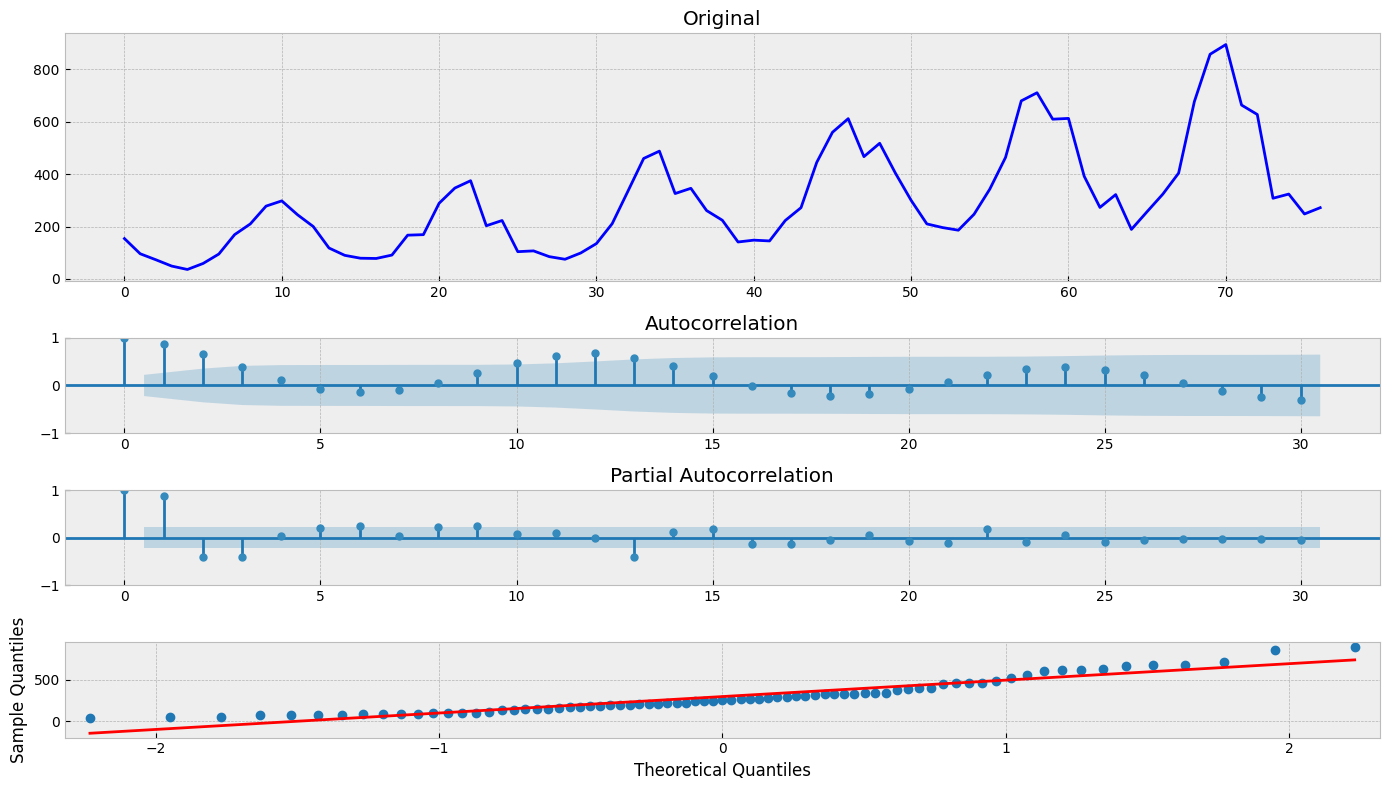

In [ ]:
tsplot(series, lags=30)

## Нормализуем дисперсию

In [ ]:
series = series.apply(lambda x: boxcox(x,0))

In [ ]:
new_series = series

### вариант 1: однократное дифференцирование

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


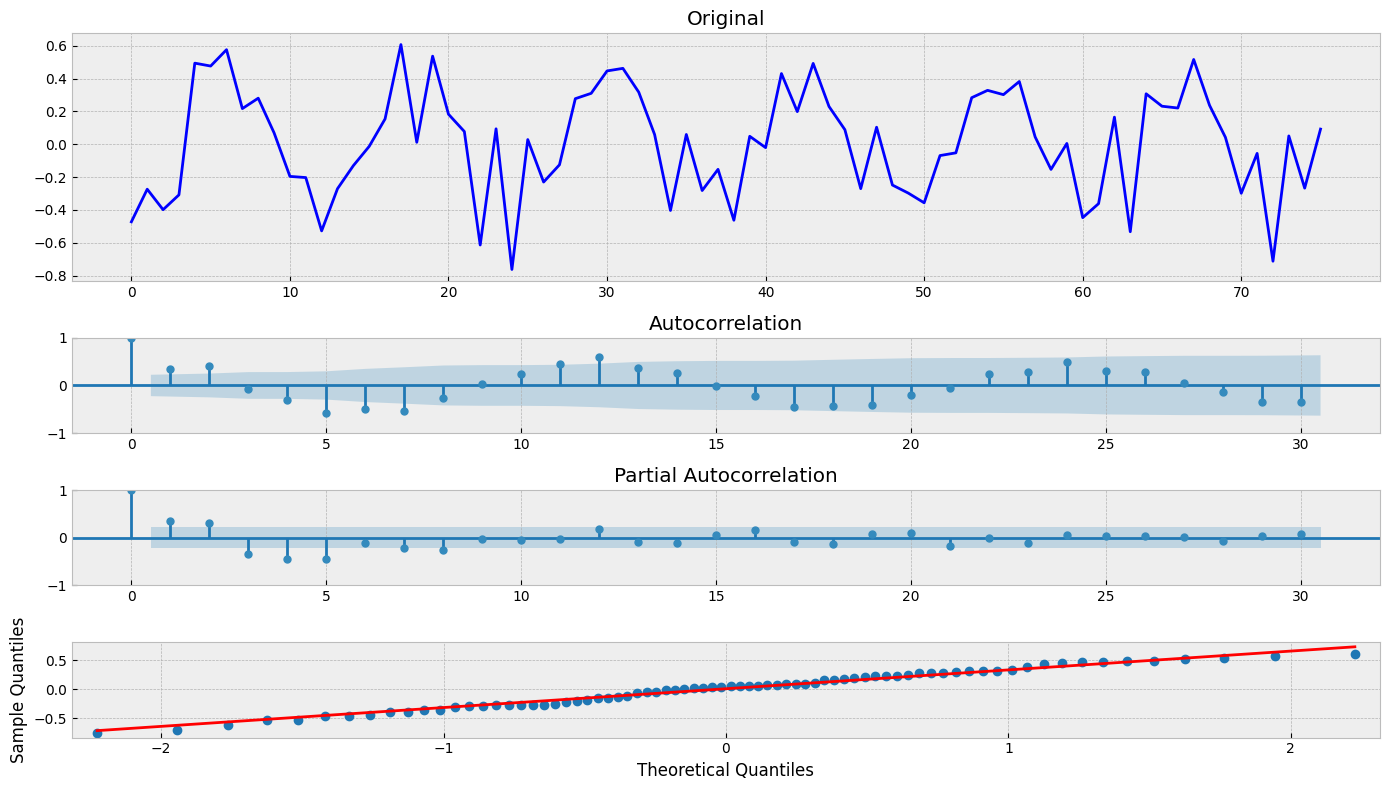

In [ ]:
series = np.diff(series)
tsplot(series, lags=30)

pvalue < 0.05 - можно пробовать модель ARIMA

In [ ]:
best_mdl, best_method, best_order = tune_model(series)
print(best_method)
print('aic: {:6.5f} | order: {}'.format(best_mdl.aic, best_order))

innovations_mle
aic: -33.21456 | order: (3, 0, 2)


In [ ]:
results = dict()
results[(best_order)]=best_mdl.aic

Results of Dickey-Fuller Test:
Test Statistic                -8.966833e+00
p-value                        7.947262e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (5%)           -2.901470e+00
Critical Value (10%)          -2.588072e+00
dtype: float64


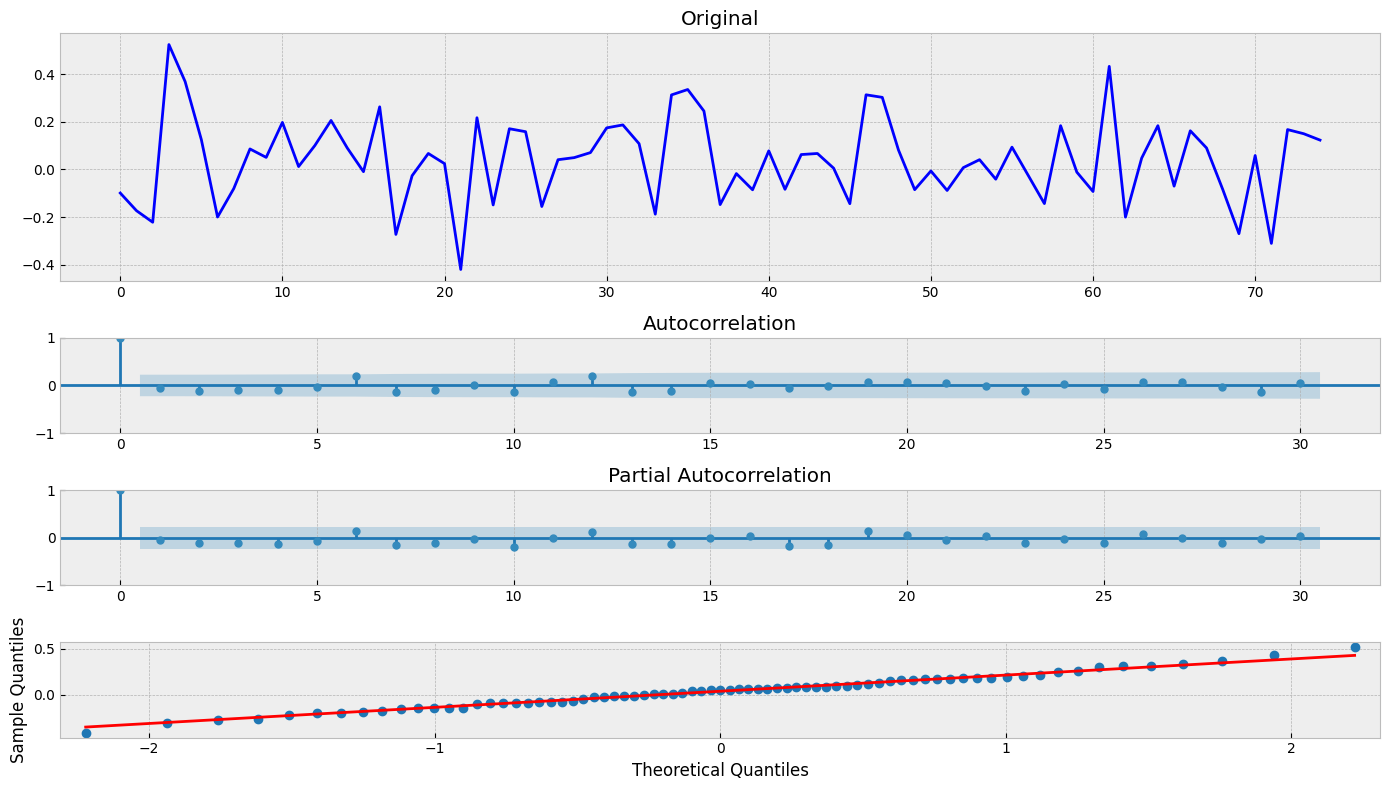

In [ ]:
tsplot(best_mdl.resid[1:], lags=30)

In [ ]:
sm.stats.durbin_watson(best_mdl.resid) # значение билизко к 2, слабая корреляция остатков

1.8814658417094676

In [ ]:
print(best_mdl.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   76
Model:                 ARIMA(3, 0, 2)   Log Likelihood                  22.607
Date:                Wed, 22 Nov 2023   AIC                            -33.215
Time:                        17:35:35   BIC                            -19.230
Sample:                             0   HQIC                           -27.626
                                 - 76                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1824      0.100     11.851      0.000       0.987       1.378
ar.L2         -0.0464      0.173     -0.267      0.789      -0.386       0.294
ar.L3         -0.5480      0.100     -5.482      0.0

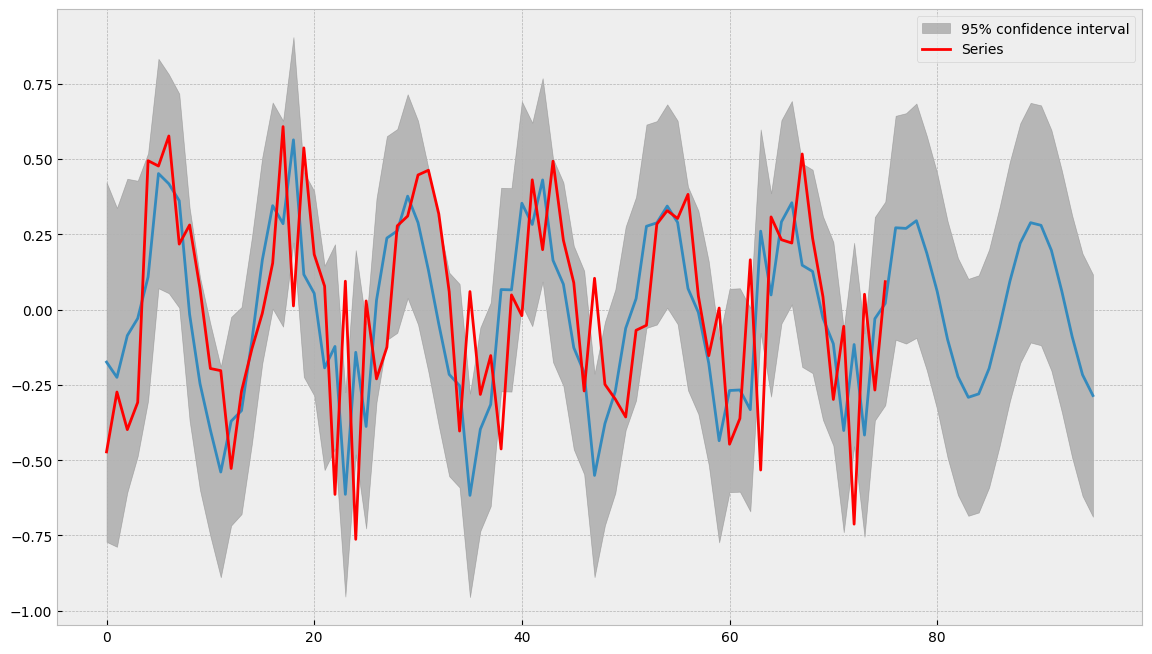

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

### вариант 2: двойное дифференцирование

Results of Dickey-Fuller Test:
Test Statistic                -7.101182e+00
p-value                        4.164137e-10
#Lags Used                     1.100000e+01
Number of Observations Used    6.300000e+01
Critical Value (1%)           -3.538695e+00
Critical Value (5%)           -2.908645e+00
Critical Value (10%)          -2.591897e+00
dtype: float64


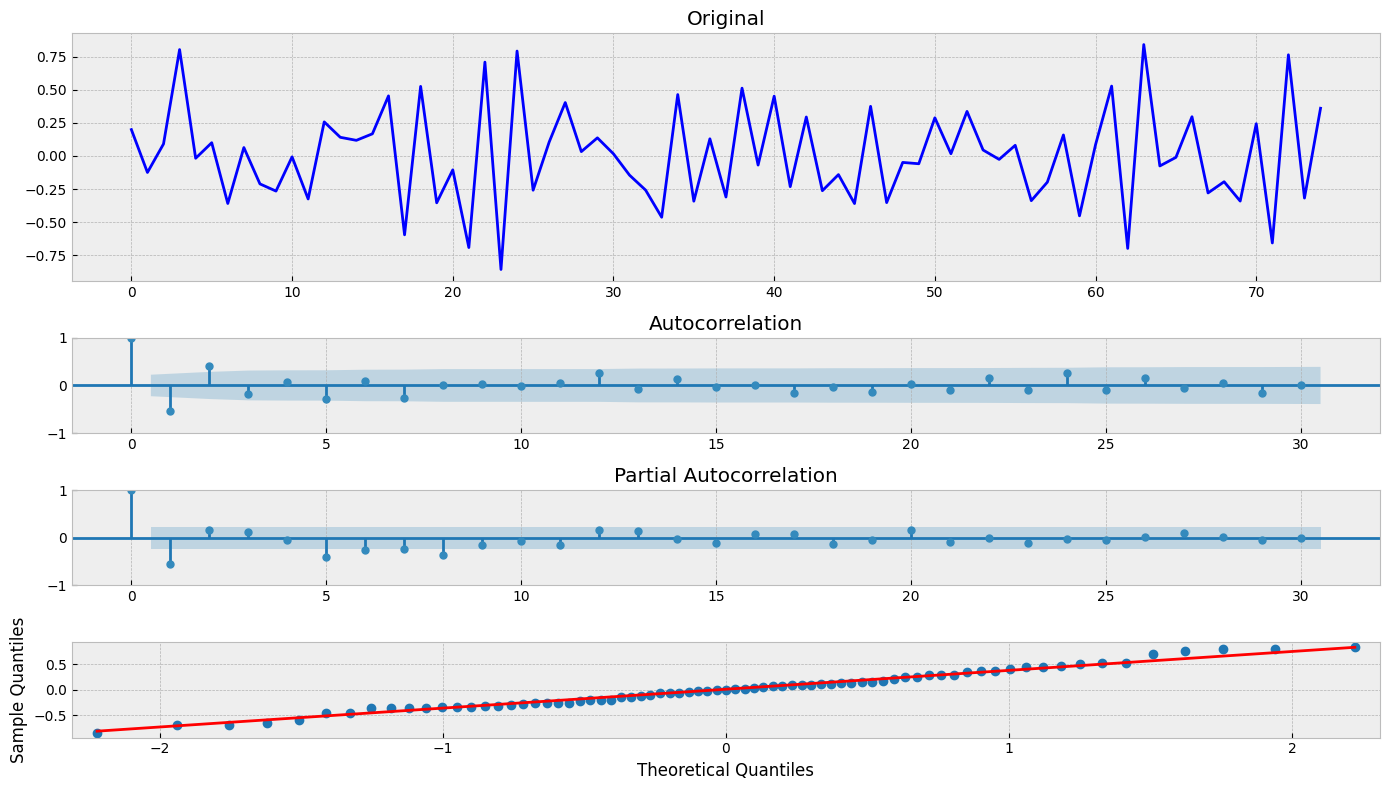

In [ ]:
new_series = np.diff(new_series, n=2)
tsplot(new_series, lags=30)

pvalue << 0.05 - можно пробовать модель ARIMA

In [ ]:
best_mdl, best_method, best_order = tune_model(new_series)
print(best_method)
print('aic: {:6.5f} | order: {}'.format(best_mdl.aic, best_order))

innovations_mle
aic: -16.82308 | order: (4, 0, 2)


In [ ]:
results[(best_order)] = best_mdl.aic

Results of Dickey-Fuller Test:
Test Statistic                 -2.420175
p-value                         0.136123
#Lags Used                      5.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


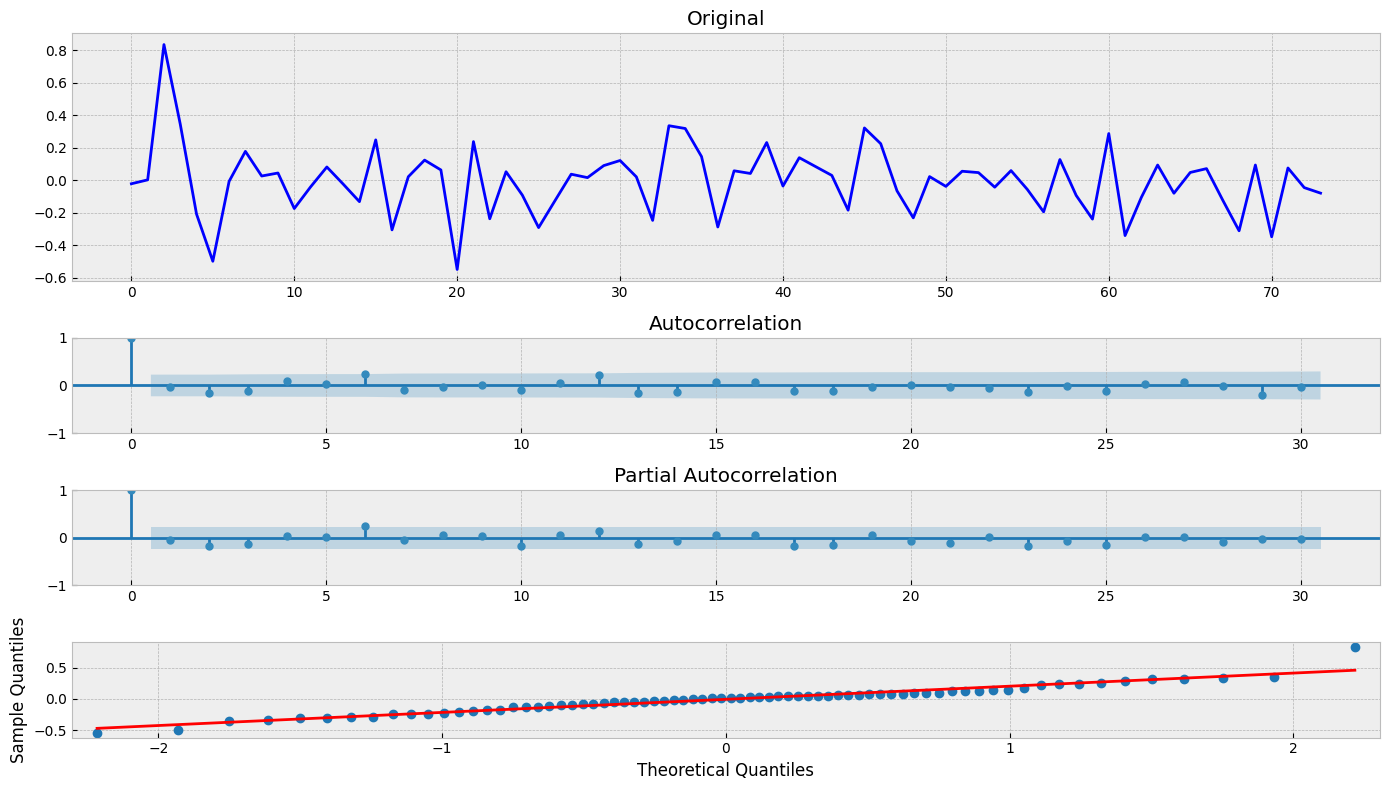

In [ ]:
tsplot(best_mdl.resid[1:], lags=30)

In [ ]:
sm.stats.durbin_watson(best_mdl.resid) # значение билизко к 2, слабая корреляция остатков

2.072184717995619

In [ ]:
print(best_mdl.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:                 ARIMA(4, 0, 2)   Log Likelihood                  15.412
Date:                Wed, 22 Nov 2023   AIC                            -16.823
Time:                        17:43:44   BIC                             -0.601
Sample:                             0   HQIC                           -10.346
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5683      0.112      5.084      0.000       0.349       0.787
ar.L2          0.4846      0.129      3.753      0.000       0.232       0.738
ar.L3         -0.3056      0.147     -2.086      0.0

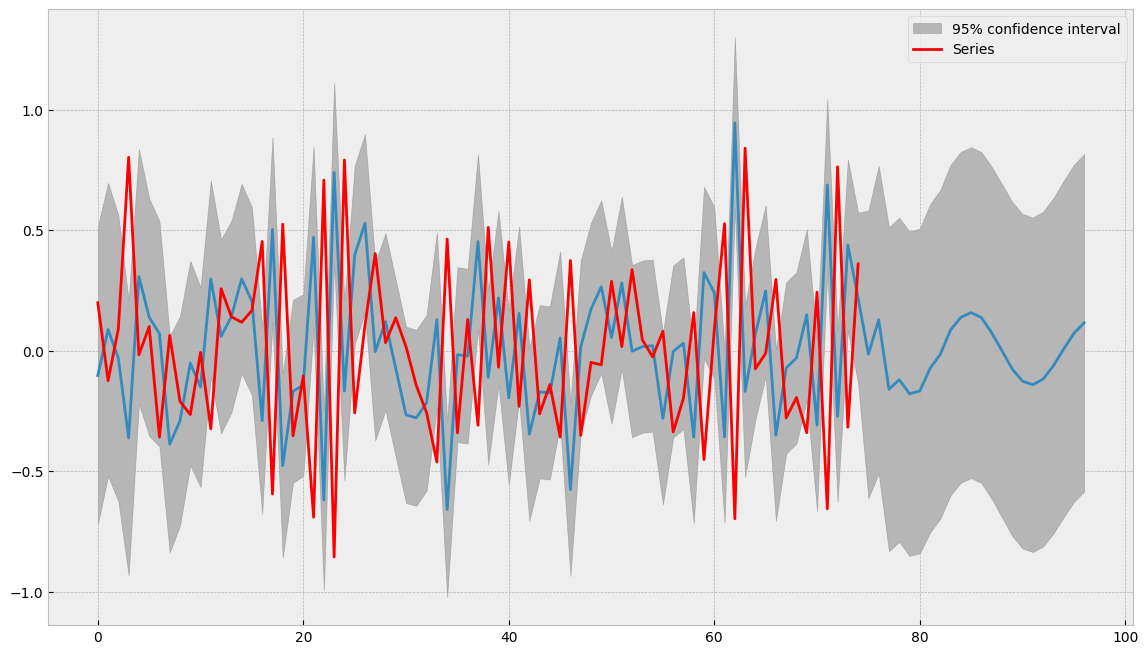

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(series)+20, ax=ax)
    plt.plot(new_series, color='red', label='Series')
    plt.legend()
    plt.show()

In [ ]:
print(results)

{(3, 0, 2): -33.21456465601082, (4, 0, 2): -16.823079077521406}


И по величине AIC, и визуально первый вариант модели выглядит более предпочтительным по сравнению со вторым

# Попробуйте спрогнозировать график классическим ML

In [ ]:
ts = pd.read_csv("/content/drive/MyDrive/TSML13_DZ1/Series/weekly-closings-of-the-dowjones-.csv")

In [ ]:
X_train, X_test, y_train, y_test = prepareData(ts, lag_start=1, lag_end=13, test_size=0.3)

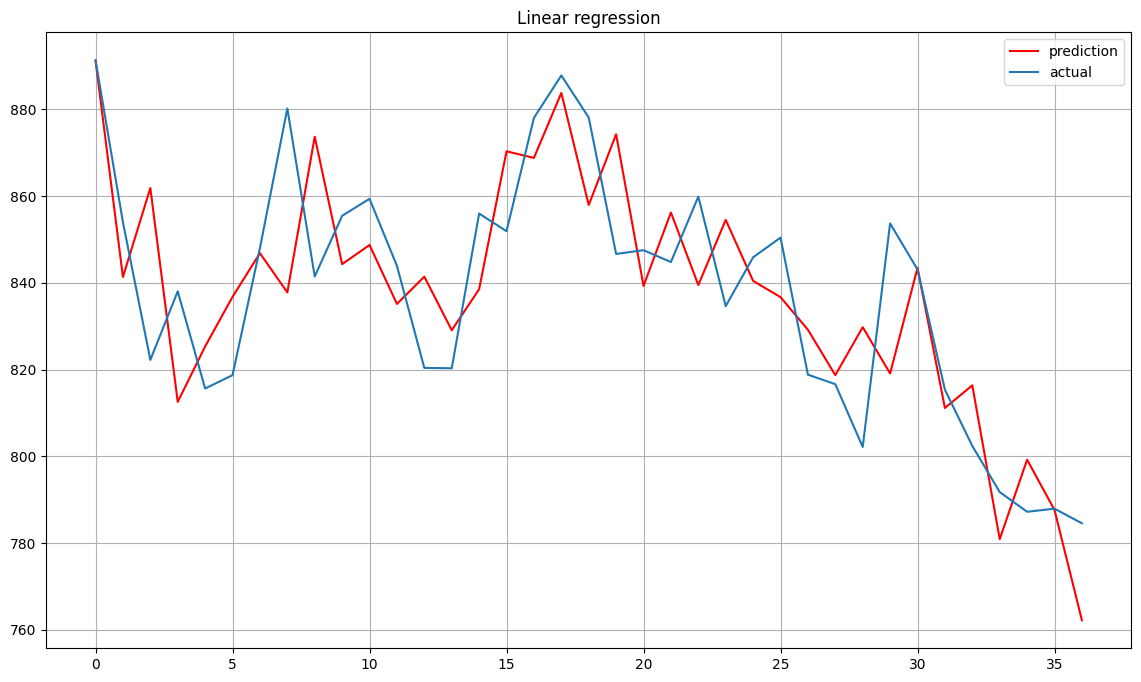

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);